# 1. Comparación de sistemas lineales vs. no lineales

| Característica                    | Lineal                                      | No lineal (SIR)                                      |
|-----------------------------------|---------------------------------------------|------------------------------------------------------|
| **Ecuación básica**               | $$\frac{dI}{dt} = \mu\,I$$                 | $$\frac{dI}{dt} = \beta\,S\,I \;-\;\mu\,I$$          |
| **Principio de superposición**    | Válido: la suma de soluciones es solución.  | No válido: no se pueden sumar soluciones arbitrarias.|
| **Escalabilidad**                 | Escala horaria uniforme: si $$t\mapsto I(t)$$ es solución, $$I(at)$$ también lo es. | Dependiente de $$S(t)$$; cambiar escala rompe la dinámica. |
| **Solución analítica**            | Disponible en forma cerrada:  
$I(t)=I_0 e^{\mu t}$              | Generalmente no hay solución cerrada → requiere simulación numérica. |
| **Respuesta a perturbaciones**    | Siempre exponencial; sin saturación ni umbrales. | Puede presentar **umbrales** (p.ej. $$R_0=1$$), saturación y puntos de inflexión. |
| **Dinámica temporal**             | Monótona (crece o decae).                   | Pico epidémico y fase de declive: curva con máximo.  |
| **Estabilidad de equilibrio**     | Único equilibrio en $$I=0$$ (estable si $$\mu<0$$). | Múltiples equilibria (sano vs. endémico) y cambio de estabilidad según $$R_0$$. |
| **Aplicaciones típicas**          | Modelos de crecimiento/decadencia simple (radioactividad, población sin límite). | Modelado de epidemias, sistemas con interacción “agente–medio”. |
| **Requerimiento computacional**   | Bajo: basta fórmula analítica.              | Medio/alto: integración numérica (Euler, Runge–Kutta). |
| **Comportamientos emergentes**    | Ninguno: no aparece dinámica compleja.      | Oscilaciones suaves, umbrales críticos, posibles bifurcaciones en extensiones (SIRS, SEIR). |




---

# 2. Fuerza de infección $$\lambda$$

Se define como  
$$
\lambda = \frac{\beta\,c\,I}{N}
$$

- **Riesgo por susceptibilidad**  
  Es la probabilidad instantánea de que un individuo susceptible se infecte.

- **Tasa de propagación por infección**  
  Es el número de nuevos casos por infectado y por unidad de tiempo, ajustado al tamaño de la población.

---

# 3. Por qué simular sistemas no lineales

- **Ausencia de soluciones cerradas**  
  La dependencia mutua de las variables (S, I, R) impide casi siempre resolver analíticamente.

- **Dinámicas complejas**  
  Pueden surgir bifurcaciones, picos, oscilaciones o comportamientos caóticos.

- **Métodos numéricos**  
  Se usan esquemas como Euler o Runge–Kutta para aproximar la evolución en el tiempo.

---

# 4. Modelo SIR con $$R_0 = 3$$

## a. ¿Qué es $$R_0$$?

El **número reproductivo básico** $$R_0$$ es  
$$
R_0 = \frac{\beta\,S_0}{\mu}
$$  
y representa el número promedio de casos secundarios generados por un infectado en población totalmente susceptible.

## b. Umbral de inmunidad de grupo

El umbral crítico $$p_c$$ es  
$$
p_c = 1 - \frac{1}{R_0}
\quad\Longrightarrow\quad
p_c = 1 - \frac{1}{3} = \frac{2}{3} \approx 66.7\%
$$

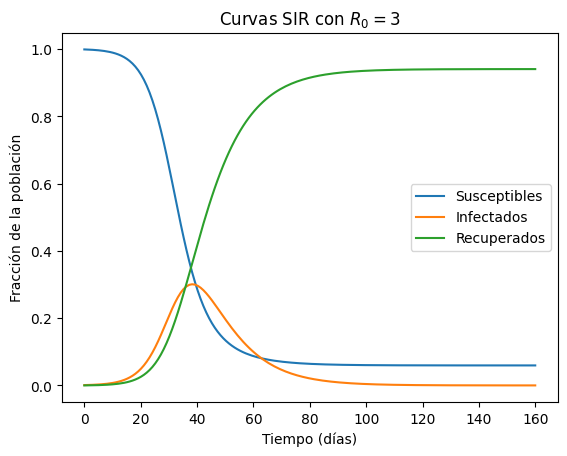

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Parámetros
R0 = 3
mu = 1/10          # tasa de recuperación
beta = R0 * mu     # tasa de transmisión
N = 1.0            # población normalizada
I0, R0_init = 1e-3, 0.0
S0 = N - I0 - R0_init
t = np.linspace(0, 160, 160)

# Ecuaciones SIR
def sir(y, t, beta, mu):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt =  beta * S * I - mu * I
    dRdt =  mu * I
    return dSdt, dIdt, dRdt

# Simulación
y0 = S0, I0, R0_init
sol = odeint(sir, y0, t, args=(beta, mu))
S, I, R = sol.T

# Gráfica
plt.plot(t, S, label='Susceptibles')
plt.plot(t, I, label='Infectados')
plt.plot(t, R, label='Recuperados')
plt.xlabel('Tiempo (días)')
plt.ylabel('Fracción de la población')
plt.legend()
plt.title('Curvas SIR con $R_0=3$')
plt.show()

## d. ¿Por qué el término $ \beta S I$ crea puntos de inflexión?

El término $ \beta S I$ es **no lineal** porque depende del producto de dos variables dinámicas, $S$ e $I$.

1. **Fase de aceleración**  
   Al inicio de la epidemia, $S$ es alto y el número de infectados crece rápidamente. La ecuación  
   $$
   \frac{dI}{dt} = \beta\,S\,I \;-\; \mu\,I
   $$  
   tiene segunda derivada positiva, $\ddot I > 0$, por lo que la curva de $I(t)$ se **concavea hacia arriba**.

2. **Fase de desaceleración**  
   A medida que $S$ disminuye, el término $\beta\,S\,I$ deja de aumentar aunque $I$ siga siendo grande. En ese punto:  
   - $\dot I$ alcanza su **máximo**.  
   - $\ddot I$ cambia de signo, pasando a $\ddot I < 0$, marcando el **punto de inflexión** en $I(t)$.

3. **Interpretación**  
   - La fuerza de infección $\beta\,S\,I$ es máxima cuando la interacción entre susceptibles e infectados es mayor.  
   - Cuando el número de susceptibles se reduce, la retroalimentación positiva se atenúa, provocando el pico epidémico y el cambio de concavidad.

En resumen, la no linealidad del término $ \beta S I$ genera una fase inicial de aceleración y una fase posterior de desaceleración, definidas por puntos de inflexión en la curva de infectados.


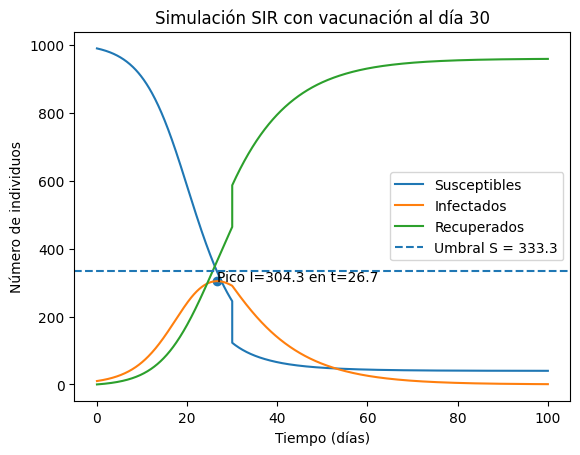

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# 1. Inicializar poblaciones
S0, I0, R0 = 990, 10, 0
N = S0 + I0 + R0

# 2. Parámetros
beta, mu = 0.3, 0.1  # R0 = beta/mu = 3

# 3. Modelo SIR
def sir(t, y):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - mu * I
    dRdt = mu * I
    return [dSdt, dIdt, dRdt]

# Integración 0–30 días
t1 = np.linspace(0, 30, 301)
sol1 = solve_ivp(sir, [0, 30], [S0, I0, R0], t_eval=t1)

# 5. Vacunación al día 30 (50% de S pasa a R)
S30, I30, R30 = sol1.y[:, -1]
vaccinated = 0.5 * S30
S30_v = S30 - vaccinated
R30_v = R30 + vaccinated
I30_v = I30

# Integración 30–100 días
t2 = np.linspace(30, 100, 701)
sol2 = solve_ivp(sir, [30, 100], [S30_v, I30_v, R30_v], t_eval=t2)

# 4. Combinar resultados
t = np.concatenate((sol1.t, sol2.t))
S = np.concatenate((sol1.y[0], sol2.y[0]))
I = np.concatenate((sol1.y[1], sol2.y[1]))
R = np.concatenate((sol1.y[2], sol2.y[2]))

# 5. Anotar pico de infección y umbral de inmunidad de grupo
peak_idx = np.argmax(I)
t_peak = t[peak_idx]
I_peak = I[peak_idx]
S_threshold = N * (mu / beta)  # S_c = N / R0

# 4. Gráfica
plt.figure()
plt.plot(t, S, label='Susceptibles')
plt.plot(t, I, label='Infectados')
plt.plot(t, R, label='Recuperados')
plt.axhline(S_threshold, linestyle='--', label=f'Umbral S = {S_threshold:.1f}')
plt.scatter([t_peak], [I_peak])
plt.text(t_peak, I_peak, f'Pico I={I_peak:.1f} en t={t_peak:.1f}')
plt.xlabel('Tiempo (días)')
plt.ylabel('Número de individuos')
plt.legend()
plt.title('Simulación SIR con vacunación al día 30')
plt.show()


## Análisis de la gráfica SIR con vacunación al día 30

**1. Descripción general**  
- Población inicial: $S_0 = 990$, $I_0 = 10$, $R_0 = 0$.  
- Parámetros: $\beta = 0.3\ /\text{día}$, $\mu = 0.1\ /\text{día}$ $\implies R_0 = \beta/\mu = 3$.  
- Vacunación: al día 30 se vacuna al 50 % de los susceptibles.

---

**2. Dinámica de las curvas**  
- **Susceptibles (azul):**  
  - Desciende de forma continua por infecciones.  
  - En $t = 30$ hay un **colapso brusco**, al reducirse la mitad de $S$ por vacunación.  
- **Infectados (naranja):**  
  - Aumenta rápidamente hasta un **pico de $\approx 304$ infectados** en $t \approx 26.7$ días.  
  - Tras el pico, cae de forma monótona y se acelera después de la vacunación.  
- **Recuperados (verde):**  
  - Crece de manera continua por recuperaciones.  
  - Salto en $t = 30$ al añadir los vacunados a la categoría “recuperados”.

---

**3. Umbral de inmunidad de grupo**  
- Línea punteada horizontal en  
  $$
  S_c = \frac{N}{R_0} = \frac{1000}{3} \approx 333.3
  $$
- Cuando $S(t)$ cruza por debajo de $S_c$, la derivada neta de infectados  
  $$
  \dot I = \frac{\beta\,S\,I}{N} \;-\; \mu\,I
  $$
  pasa de positiva a negativa, marcando el pico de la epidemia.

---

**4. Impacto de la vacunación**  
- **Antes de $t = 30$**  
  - El sistema sigue la evolución típica SIR: pico y declive suave.  
- **En $t = 30$**  
  - Reducir $S$ por debajo de $S_c$ **refuerza** la caída de $I$.  
  - Se observa un menor número de infectados posteriores y una mayor proporción de población inmune.

---

**5. Conclusiones prácticas**  
- Una intervención de vacunación **post-pico** puede acelerar la extinción de la epidemia.  
- Conocer $S_c$ permite **predecir** el momento óptimo para intervenir y cuantificar la cobertura necesaria.
